In [ ]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image
import time

#Data

##Load data



In [ ]:
ROOT = './data'
train_data = datasets.MNIST(
    root = ROOT,
    train = True,
    download = True
)
test_data = datasets.MNIST(
    root = ROOT,
    train = False,
    download = True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



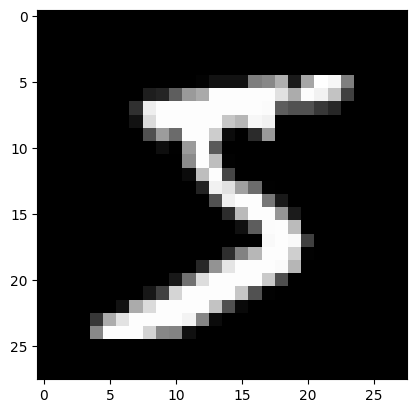

In [ ]:
plt.imshow(train_data.data[0], cmap='gray')
plt.show()

##Split data

In [ ]:
VALID_RATIO = 0.9

n_train_samples = int(len(train_data) * VALID_RATIO)
n_valid_samples = len(train_data) - n_train_samples

train_data, valid_data = data.random_split(
  train_data,
  [n_train_samples, n_valid_samples]
)

##Standardize data

In [ ]:
mean = train_data.dataset.data.float().mean() / 256
std = train_data.dataset.data.float().std() / 256

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

##Create dataloader

In [ ]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle = True,
    batch_size = BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size = BATCH_SIZE
)

#Modeling

##Model

In [ ]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(
        in_channels = 1, out_channels = 6, kernel_size = 5,
        padding = 'same'
    )
    self.avgpool1 = nn.AvgPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(
        in_channels = 6, out_channels = 16, kernel_size = 5
    )
    self.avgpool2 = nn.AvgPool2d(kernel_size = 2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 16 * 5 * 5, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = num_classes)

  def forward(self, x):
    outputs = self.conv1(x)
    outputs = self.avgpool1(outputs)
    outputs = F.relu(outputs)
    outputs = self.conv2(outputs)
    outputs = self.avgpool2(outputs)
    outputs = F.relu(outputs)
    outputs = self.flatten(outputs)
    outputs = self.fc1(outputs)
    outputs = self.fc2(outputs)
    outputs = self.fc3(outputs)
    return outputs

##Training function

In [ ]:
def train(model, optimizer, criterion, dataloader, device, epoch = 0, log_interval = 50):
  model.train()
  total_acc, total_count = 0, 0
  losses = []
  start_time = time.time()

  for idx, (inputs, labels) in enumerate(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    #compute loss
    loss = criterion(outputs, labels)
    losses.append(loss.item())
    #backward
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

    total_acc += (outputs.argmax(1) == labels).sum().item()
    total_count += labels.size(0)

    if (idx + 1) % log_interval == 0:
      elapsed = time.time() - start_time
      print(
          '| epoch {:3d} | {:5d}/{:5d} batches '
          '| accuracy {:8.3f} | loss {:8.3f} | '.format(
              epoch, idx + 1, len(dataloader),
              total_acc / total_count, np.mean(losses)
          )
      )
      total_acc, total_count = 0, 0
      start_time = time.time()

  epoch_acc = total_acc / total_count
  epoch_loss = np.mean(losses)
  return epoch_acc, epoch_loss

##Evaluating function

In [ ]:
def evaluate(model, criterion, dataloader, device):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []

  with torch.no_grad():
    for idx, (inputs, labels) in enumerate(dataloader):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      total_acc += (outputs.argmax(1) == labels).sum().item()
      total_count += labels.size(0)

  epoch_acc = total_acc / total_count
  epoch_loss = np.mean(losses)
  return epoch_acc, epoch_loss

##Training

In [ ]:
num_classes = len(train_data.dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lenet_model = LeNetClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_model = './model'
if (not os.path.exists(save_model)):
  os.makedirs(save_model)

train_accs, train_losses = [], []
valid_accs, valid_losses = [], []
best_loss_val = 100

for epoch in range(1, num_epochs+1):
  train_acc, train_loss = train(
      lenet_model, optimizer, criterion, train_dataloader, device, epoch
  )
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  valid_acc, valid_loss = evaluate(
      lenet_model, criterion, valid_dataloader, device
  )
  valid_accs.append(valid_acc)
  valid_losses.append(valid_loss)

  #Save best model
  if valid_loss < best_loss_val:
    best_loss_val = valid_loss
    torch.save(lenet_model.state_dict(), save_model + '/best_model.pt')

  #Print loss, acc, epoch
  print('-'*60)
  print(
      '| end of epoch {:3d} | train accuracy {:8.3f} | train loss {:8.3f} | '
      'valid accuracy {:8.3f} | valid loss {:8.3f} | '.format(
          epoch, train_acc, train_loss, valid_acc, valid_loss
      )
  )
  print('-'*60)


| epoch   1 |    50/  211 batches | accuracy    0.679 | loss    1.164 | 
| epoch   1 |   100/  211 batches | accuracy    0.882 | loss    0.777 | 
| epoch   1 |   150/  211 batches | accuracy    0.910 | loss    0.622 | 
| epoch   1 |   200/  211 batches | accuracy    0.937 | loss    0.520 | 
------------------------------------------------------------
| end of epoch   1 | train accuracy    0.947 | train loss    0.503 | valid accuracy    0.947 | valid loss    0.181 | 
------------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.954 | loss    0.154 | 
| epoch   2 |   100/  211 batches | accuracy    0.961 | loss    0.143 | 
| epoch   2 |   150/  211 batches | accuracy    0.967 | loss    0.132 | 
| epoch   2 |   200/  211 batches | accuracy    0.968 | loss    0.126 | 
------------------------------------------------------------
| end of epoch   2 | train accuracy    0.972 | train loss    0.124 | valid accuracy    0.970 | valid loss    0.107 

##Visualize

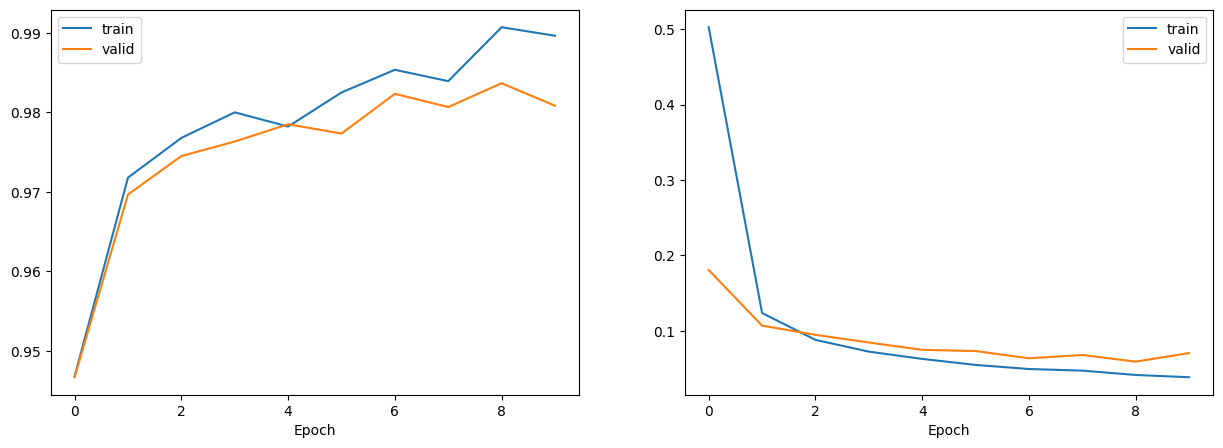

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(train_accs, label = 'train')
ax[0].plot(valid_accs, label = 'valid')

ax[1].plot(train_losses, label = 'train')
ax[1].plot(valid_losses, label = 'valid')

for i in range(2):
  ax[i].set_xlabel('Epoch')
  ax[i].legend()


##Evaluating model

In [ ]:
lenet_model.load_state_dict(torch.load(save_model + '/best_model.pt'))

test_data.transform = test_transforms
test_dataloader = data.DataLoader(
    test_data,
    batch_size = BATCH_SIZE
)

test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
print('Test accuracy: {:8.3f} | Test loss: {:8.3f}'.format(test_acc, test_loss))

<ipython-input-21-ad8686bf5ee0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model + '/best_model.pt'))


Test accuracy:    0.986 | Test loss:    0.044


##Download

In [ ]:
from google.colab import files

#download model and data
files.download(save_model + '/best_model.pt')
files.download('/content/data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>